

### **Text Cell**

# Day 2 (Part 2): The Optimized CNN Solution

**Welcome to the second half of Day 2\!**

In the last notebook, we saw our Multi-Layer Perceptron (MLP) **fail** on the fruits dataset. It overfit massively because the `Flatten` layer destroyed all the spatial information.

**Today's Goal:**

According to our FDP schedule, the practical session for Day 2 is to "Design efficient nets." This means we are jumping straight to the solution: the **Optimized Convolutional Neural Network (CNN)**.

We will learn the theory of **Optimization** and **Regularization** and build a "pro" model that fixes all the problems our MLP had.

**Our Plan:**

1.  **Prove Overfitting:** We'll first build a "Basic" CNN that is *designed* to overfit, creating a clear problem.
2.  **Learn the Theory:** We'll cover the *why* and *how* of optimization techniques:
      * Batch Normalization
      * L1/L2 Regularization
      * Dropout
      * Early Stopping
3.  **Build an Optimized Model:** We will build our "efficient net" using these techniques.
4.  **Compare and Prove:** We'll train the new model and plot its performance side-by-side with our baseline to *prove* these techniques work.

-----

### **Text Cell**

## Cell 1: Setup - Importing Libraries

As always, we start with our imports.

-----

### **Code Cell**

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

print(f"TensorFlow Version: {tf.__version__}")
print("All libraries imported.")

TensorFlow Version: 2.19.0
All libraries imported.


-----

### **Text Cell**

## Cell 2: Define Dataset Parameters

We must use the *exact same* parameters as our last notebook for a fair comparison.

-----

### **Code Cell**

In [2]:
# We will resize all images to 64x64
IMG_SIZE = 64
print(f"Image size set to: {IMG_SIZE}x{IMG_SIZE} pixels")

# We will train in batches of 32 images at a time
BATCH_SIZE = 32
print(f"Batch size set to: {BATCH_SIZE}")

# Our images have 3 color channels (R, G, B)
CHANNELS = 3
print(f"Number of color channels: {CHANNELS}")

# Our dataset has 6 classes
NUM_CLASSES = 6
print(f"Number of classes: {NUM_CLASSES}")

Image size set to: 64x64 pixels
Batch size set to: 32
Number of color channels: 3
Number of classes: 6


-----

### **Text Cell**

## Cell 3: Define File Paths

This cell will download the dataset from Kaggle. This is perfect for Google Colab.

-----

### **Code Cell**

In [5]:
# =============================================
# Execute this code only when you Dont have dataset || prefer when you are executing this in Google colab
# ==============================================
# Download the dataset from Kaggle using kagglehub

import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sriramr/fruits-fresh-and-rotten-for-classification")

print("Path to dataset files:", path)

# The downloaded dataset structure is typically dataset/train and dataset/test
# Adjust the base_dir to point to the extracted dataset folder
base_dir = os.path.join(path, "dataset")

print(f"Base directory: {base_dir}")
print("Exists:", os.path.exists(base_dir))


# Training data path
train_dir = os.path.join(base_dir, "train")
print(f"Training data path: {train_dir}")
print("Exists:", os.path.exists(train_dir))

# Test data path
test_dir = os.path.join(base_dir, "test")
print(f"Test data path: {test_dir}")
print("Exists:", os.path.exists(test_dir))

Using Colab cache for faster access to the 'fruits-fresh-and-rotten-for-classification' dataset.
Path to dataset files: /kaggle/input/fruits-fresh-and-rotten-for-classification
Base directory: /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset
Exists: True
Training data path: /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train
Exists: True
Test data path: /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test
Exists: True


-----

### **Text Cell**

## Cell 4: Load and Prepare Datasets

We'll do all the loading and preparation in one go.

-----

### **Code Cell**

In [6]:
# Load Training Data
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
print("Loaded Training Data.")

# Load Validation/Test Data
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
print("Loaded Validation (Test) Data.")

# Get Class Names
class_names = train_dataset.class_names
print(f"Class names found: {class_names}")

# Configure for Performance
AUTOTUNE = tf.data.AUTOTUNE
print(f"Setting AUTOTUNE to {AUTOTUNE}")

# Apply .cache() and .prefetch() to the training dataset
train_ds = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
print("Applied .cache() and .prefetch() to training dataset.")

# Apply .cache() and .prefetch() to the validation dataset
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
print("Applied .cache() and .prefetch() to validation dataset.")

Found 10901 files belonging to 6 classes.
Loaded Training Data.
Found 2698 files belonging to 6 classes.
Loaded Validation (Test) Data.
Class names found: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']
Setting AUTOTUNE to -1
Applied .cache() and .prefetch() to training dataset.
Applied .cache() and .prefetch() to validation dataset.


### Visualizing the 64x64 Resize
You asked why we picked IMG_SIZE = 64. Let's visualize what that resizing looks like. We'll load one image from the disk twice: once in its original size and once resized to 64x64.

You can see how the 64x64 version is much smaller and "blockier," but it still keeps the main features (the apple's shape and color).

Loading example image: /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/freshapples/saltandpepper_Screen Shot 2018-06-08 at 5.18.26 PM.png


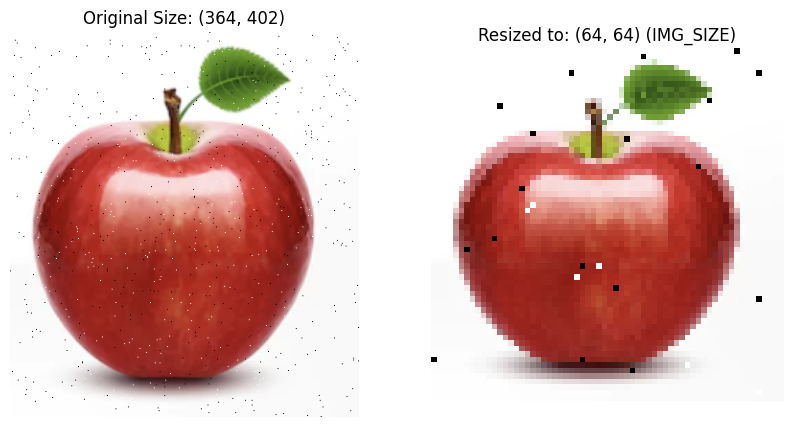

In [7]:
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
import os

# --- Find an example image ---
# NOTE: This assumes you have 'freshapples' folder in your train_dir
# We'll get the first image we find in that folder
try:
    example_img_folder = os.path.join(train_dir, 'freshapples')
    example_img_name = os.listdir(example_img_folder)[0]
    example_img_path = os.path.join(example_img_folder, example_img_name)

    print(f"Loading example image: {example_img_path}")

    # --- Load images ---
    # 1. Load the original
    original_img = load_img(example_img_path)

    # 2. Load the 64x64 version
    resized_img = load_img(example_img_path, target_size=(IMG_SIZE, IMG_SIZE))

    # --- Plot them side-by-side ---
    plt.figure(figsize=(10, 5))

    # Plot Original
    plt.subplot(1, 2, 1)
    plt.title(f"Original Size: {original_img.size}")
    plt.imshow(original_img)
    plt.axis('off')

    # Plot Resized
    plt.subplot(1, 2, 2)
    plt.title(f"Resized to: {resized_img.size} (IMG_SIZE)")
    plt.imshow(resized_img)
    plt.axis('off')

    plt.show()

except FileNotFoundError:
    print("\n---")
    print("Could not find the 'freshapples' directory to load an example.")
    print(f"Please make sure your train_dir is set correctly. Current path: {train_dir}")
except Exception as e:
    print(f"An error occurred: {e}")

###Visualize the Data (Quick Check)
It's always good to look at your data. Let's make sure it loaded correctly.

Plotting 9 sample images from the training data...


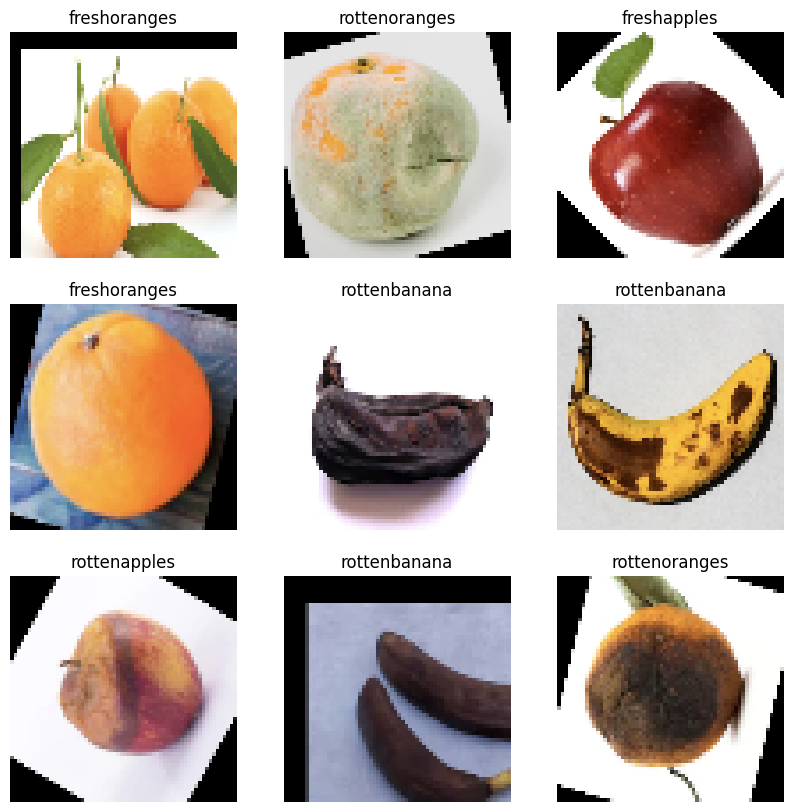

In [8]:
plt.figure(figsize=(10, 10))
print("Plotting 9 sample images from the training data...")
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_index = np.argmax(labels[i])
        plt.title(class_names[class_index])
        plt.axis("off")
plt.show()

-----

### **Text Cell**

-----

## Part 1: Proving Overfitting (The "Basic" CNN)

## To demonstrate the lesson, we will **intentionally build a larger "Baseline" model** (`32 -> 64 -> 128`) and add a **very large `Dense` layer (`512`)**. This creates a powerful model with no regularization, making it *highly likely* to overfit. This gives our Optimized model a clear problem to solve.

-----

### **Text Cell**

## Cell 5: Build the Baseline CNN (Designed to Overfit)

This is our **Overfitting Baseline CNN**. It is deep and has a massive `Dense` layer, which makes it very powerful but unstable—perfect for demonstrating overfitting.

**Baseline Architecture:**

1.  `Rescaling`: Normalize pixels.
2.  `Conv2D`: **32** filters.
3.  `MaxPooling2D`: Shrink.
4.  `Conv2D`: **64** filters.
5.  `MaxPooling2D`: Shrink.
6.  `Conv2D`: **128** filters.
7.  `MaxPooling2D`: Shrink.
8.  `Flatten`: Unroll features.
9.  `Dense`: **512**-neuron hidden layer (The "Overfitting" layer)
10. `Dense`: 6-neuron output layer.

-----

### **Code Cell**

In [9]:
# --- Cell 5: Build the Baseline CNN (FIXED: Functional API) ---
# We build this model using the Functional API to solve the "AttributeError".
# This gives us a clear 'inputs' tensor we can use later for visualization.
# The architecture is IDENTICAL to your original baseline.

# 1. Define the Input
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_layer')

# 2. Rescale
x = tf.keras.layers.Rescaling(1./255)(inputs)

# 3. First Convolution block
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2d_1')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), name='max_pooling2d_1')(x)

# 4. Second Convolution block
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_2')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), name='max_pooling2d_2')(x)

# 5. Flatten
x = tf.keras.layers.Flatten(name='flatten_1')(x)

# 6. Dense hidden layer
x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(x)

# 7. Output
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='dense_2')(x)

# Create the model
model_baseline = tf.keras.Model(inputs=inputs, outputs=outputs, name="baseline_cnn_functional")

print("Baseline CNN (Functional API) built successfully.")
model_baseline.summary()

Baseline CNN (Functional API) built successfully.


Model: "baseline_cnn_functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,950 (1.55 MB)

 Trainable params: 406,950 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

-----

### **Text Cell**

## Cell 6: Compile the Baseline CNN

Same compilation settings.

-----

### **Code Cell**

In [10]:
model_baseline.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Baseline CNN compiled with 'adam' optimizer and 'categorical_crossentropy' loss.")

Baseline CNN compiled with 'adam' optimizer and 'categorical_crossentropy' loss.


-----

### **Text Cell**

## Cell 7: Train the Baseline CNN

We'll train for 20 epochs. Because this model is larger, it should learn the training data (`accuracy`) very fast, but start to fail on the *validation* data (stagnant `val_accuracy` and rising `val_loss`).

-----

### **Code Cell**

In [11]:
print("Starting Baseline CNN training for 20 epochs...")
# We'll save the history to plot it
history_baseline = model_baseline.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    verbose=1 # Show progress
)

print("\nBaseline CNN training complete.")

Starting Baseline CNN training for 20 epochs...
Epoch 1/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 64s 174ms/step - accuracy: 0.5768 - loss: 1.0913 - val_accuracy: 0.8755 - val_loss: 0.3717
Epoch 2/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8865 - loss: 0.3369 - val_accuracy: 0.9059 - val_loss: 0.2503
Epoch 3/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9183 - loss: 0.2398 - val_accuracy: 0.9222 - val_loss: 0.2115
Epoch 4/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9331 - loss: 0.1844 - val_accuracy: 0.9303 - val_loss: 0.1924
Epoch 5/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9492 - loss: 0.1391 - val_accuracy: 0.9296 - val_loss: 0.2024
Epoch 6/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9581 - loss: 0.1105 - val_accuracy: 0.9444 - val_loss: 0.1512
Epoch 7/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9690 - loss: 0.0888 - val_accuracy: 0.9455 - val_loss: 0.1521
Epoch 8/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step -

-----

### **Text Cell**

## Cell 8: Plot Baseline History (Loss)

Let's plot the loss. You should see a **clear gap** form: the `loss` (blue) line will keep dropping, while the `val_loss` (orange) line flattens out or starts to **climb**. This is the **overfitting** we wanted to see\!

-----

### **Code Cell**

Converted baseline history to DataFrame.


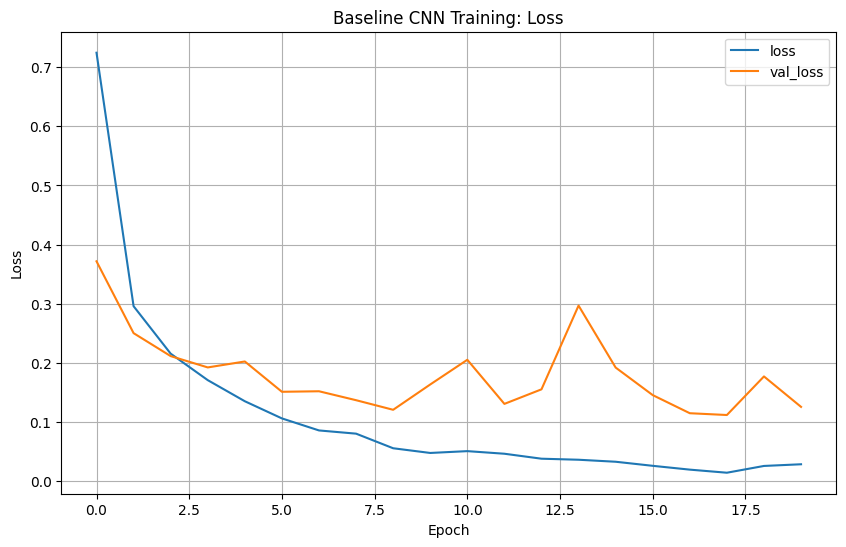

Baseline Loss plot displayed. Look for the gap between the lines!


In [12]:
# Convert the history object into a DataFrame for easier plotting
history_baseline_df = pd.DataFrame(history_baseline.history)
print("Converted baseline history to DataFrame.")

# Plot the Loss
history_baseline_df[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.title("Baseline CNN Training: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print("Baseline Loss plot displayed. Look for the gap between the lines!")

-----

### **Text Cell**

## Cell 9: Plot Baseline History (Accuracy)

You'll see the same story here. The `accuracy` (blue) will race towards 100%, but the `val_accuracy` (orange) will stall much lower. The model is *memorizing*, not *learning to generalize*.

-----

### **Code Cell**

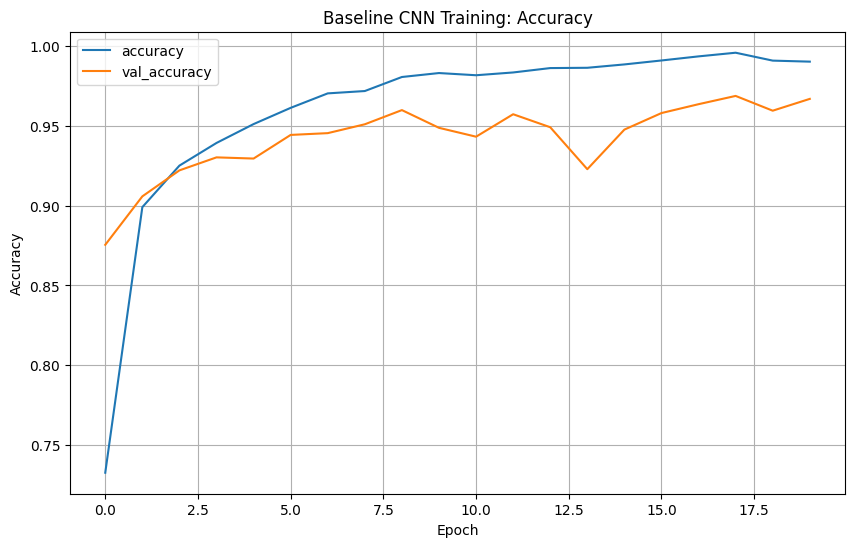

Baseline Accuracy plot displayed. The gap = overfitting!


In [13]:
# Plot the Accuracy
history_baseline_df[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.title("Baseline CNN Training: Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

print("Baseline Accuracy plot displayed. The gap = overfitting!")

-----

### **Text Cell**

-----

## Part 2: What is Overfitting and How Do We Fix It? (Theory)

The plots you just saw are a perfect example of **overfitting**.

  * **Overfitting:** The model learns the *training data* perfectly (high `accuracy`, low `loss`), but it fails to *generalize* to new, unseen data (low `val_accuracy`, high `val_loss`). It has memorized the answers instead of learning the concepts.
  * **Underfitting:** The model is too simple. It fails on *both* the training and validation data.

Our goal is the "Good Fit" curve, where both training and validation loss go down together. How do we do it? With **Regularization**.

-----

-----

### **Text Cell**

### Technique 1: Dropout

**What it is:** A layer that randomly "turns off" (sets to zero) a fraction of neurons during each training step.

**Why it works:** It forces the network to learn in a more robust way. It can't rely on any *single* neuron to be "on." It has to learn redundant pathways. It's like training a team, but random players are benched for every practice. The whole team gets stronger.

**How we use it:** `tf.keras.layers.Dropout(0.3)` (This would drop 30% of neurons). We typically add it after a Pooling or Dense layer.

-----

### **Code Cell**

In [14]:
print("Dropout theory complete.")

Dropout theory complete.


-----

### **Text Cell**

### Technique 2: Batch Normalization

**What it is:** A layer that normalizes the data *between* layers. It re-scales the output of the previous layer to have a mean of 0 and a standard deviation of 1.

**Why it works:** It stabilizes the learning process. Each layer gets data in a predictable, stable format. This prevents the "internal covariate shift" (where each layer is frantically trying to adapt to the changing statistics of the layer before it). As a bonus, it allows us to use *higher learning rates*, which speeds up training.

**How we use it:** `tf.keras.layers.BatchNormalization()`. We add it *after* a `Conv2D` or `Dense` layer, but *before* the `Activation`.

-----

### **Code Cell**

In [15]:
print("Batch Normalization theory complete.")

Batch Normalization theory complete.


-----

### **Text Cell**

### Technique 3: L1/L2 Regularization

**What it is:** A "penalty" we add to the model's loss function.

  * `L2` (most common): Adds a penalty based on the *square* of the weights.
  * `L1`: Adds a penalty based on the *absolute value* of the weights.

**Why it works:** It "discourages" the model from having massive weights. Overfitting often happens when a model "cheats" by putting a huge weight on one or two specific features. L2 regularization forces the model to "spread the blame" and use many small weights, which leads to a more general solution.

**How we use it:** We add it directly *inside* a layer: `Dense(64, kernel_regularizer=keras.regularizers.l2(0.001))`

-----

### **Code Cell**

In [16]:
print("L1/L2 Regularization theory complete.")

L1/L2 Regularization theory complete.


-----

### **Text Cell**

### Technique 4: Early Stopping

**What it is:** This isn't a layer, but a "callback." It's an assistant that *watches* the training process.

**Why it works:** We tell it to monitor a specific metric, like `val_loss`. If the `val_loss` doesn't improve for a certain number of epochs (called "patience"), the callback automatically *stops the training*.

**Why it's great:** It saves us time (we can set `epochs=100` and let it stop when it's done) and it automatically saves the *best* version of the model, not the overfitted one from the end.

**How we use it:** We create a callback object and pass it to `model.fit()`.

-----

### **Code Cell**

In [17]:
print("Early Stopping theory complete.")

Early Stopping theory complete.


-----

### **Text Cell**

-----

## Part 3: Building Our Optimized CNN (The "Pro" Net)

Now, let's build our "Pro" model. This model is **even deeper and wider** than our baseline (`32 -> 64 -> 128 -> Dense(256)`).

We will use `BatchNormalization` to stabilize the training of this deep network and `Dropout` to *control* it and prevent the overfitting we saw in the baseline.

**HIGHLIGHT - "Pro" Architecture:**

1.  `Rescaling`
2.  `Conv2D(32)` -\> **`BatchNormalization`** -\> `Activation('relu')` -\> `MaxPooling2D`
3.  `Conv2D(64)` -\> **`BatchNormalization`** -\> `Activation('relu')` -\> `MaxPooling2D` -\> **`Dropout(0.2)`**
4.  **`Conv2D(128)`** -\> **`BatchNormalization`** -\> `Activation('relu')` -\> `MaxPooling2D` -\> **`Dropout(0.3)`** (New Block\!)
5.  `Flatten`
6.  **`Dense(256)`** -\> **`BatchNormalization`** -\> `Activation('relu')` -\> **`Dropout(0.4)`** (Bigger Dense Layer)
7.  `Dense` (Output)

-----

### **Code Cell**

In [18]:
# --- Cell 10: Build the "Pro" Optimized CNN (Increased Capacity) ---
# We remove L2 regularization for now to let the model learn freely.
# Dropout and Batch Norm will handle the overfitting.

model_optimized = tf.keras.Sequential([
    # 1. Rescale
    tf.keras.layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # 2. Block 1: Learn Edges (32 Filters)
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # 3. Block 2: Learn Shapes (64 Filters)
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2), # Moderate dropout

    # 4. Block 3: Learn Patterns (128 Filters) - NEW BLOCK!
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3), # Higher dropout deeper in the network

    # 5. Flatten
    tf.keras.layers.Flatten(),

    # 6. Dense Block (Bigger Brain)
    tf.keras.layers.Dense(256), # Increased from 64 to 256
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.4), # Strong dropout before final layer

    # 7. Output
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

print("\n'Pro' CNN model built. Deeper, wider, and tuned for high accuracy.")


'Pro' CNN model built. Deeper, wider, and tuned for high accuracy.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


-----

### **Text Cell**

## Cell 11: Optimized Model Summary

Note the new layers and the much larger parameter count. This model is much more powerful.

-----

### **Code Cell**

In [19]:
model_optimized.summary()
print("\nNotice the new Conv2D and Dense layers.")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,194,118 (8.37 MB)

 Trainable params: 2,193,158 (8.37 MB)

 Non-trainable params: 960 (3.75 KB)


Notice the new Conv2D and Dense layers.


-----

### **Text Cell**

## Cell 12: Compile the Optimized CNN

We'll stick with `adam` as it's a great all-around optimizer.

-----

### **Code Cell**

In [20]:
model_optimized.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel compiled with Adam optimizer.")


Model compiled with Adam optimizer.


-----

### **Text Cell**

-----

## Part 4: Training the Optimized Model

## Now we'll train, using our `EarlyStopping` callback.

-----

### **Text Cell**

## Cell 13: Define the Early Stopping Callback

We'll tell it to:

  * `monitor`: Watch the `val_loss`.
  * `patience`: Wait 4 epochs for it to improve (since it's a bigger model).
  * `restore_best_weights`: This is key\!

-----

### **Code Cell**

In [21]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4, # Give it a little more patience
    verbose=1,
    restore_best_weights=True
)

print("\nEarlyStopping configured.")


EarlyStopping configured.


-----

### **Text Cell**

## Cell 14: Train the Optimized Model

We will set `epochs=50`. `EarlyStopping` will stop it when it finds the best version.

-----

### **Code Cell**

In [22]:
print("\nStarting 'Pro' CNN training for 50 epochs...")

history_optimized = model_optimized.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    verbose=1,
    callbacks=[early_stop]
)

print("\nTraining complete.")


Starting 'Pro' CNN training for 50 epochs...
Epoch 1/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.7599 - loss: 0.6818 - val_accuracy: 0.7891 - val_loss: 0.5533
Epoch 2/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9156 - loss: 0.2460 - val_accuracy: 0.7835 - val_loss: 0.5337
Epoch 3/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9432 - loss: 0.1658 - val_accuracy: 0.8221 - val_loss: 0.5187
Epoch 4/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9553 - loss: 0.1240 - val_accuracy: 0.8855 - val_loss: 0.3104
Epoch 5/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9666 - loss: 0.0988 - val_accuracy: 0.8862 - val_loss: 0.3061
Epoch 6/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9719 - loss: 0.0818 - val_accuracy: 0.5775 - val_loss: 1.9787
Epoch 7/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9744 - loss: 0.0708 - val_accuracy: 0.7617 - val_loss: 1.0263
Epoch 8/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - ac

-----

### **Text Cell**

## Cell 15: Check How Many Epochs Ran

Let's see if the callback worked.

-----

### **Code Cell**

In [23]:
num_epochs_ran = len(history_optimized.history['loss'])
print(f"Training stopped after {num_epochs_ran} epochs.")

Training stopped after 18 epochs.


-----

### **Text Cell**

-----

## Part 5: The Final Showdown - Baseline vs. Optimized

## This is the moment of truth. Let's plot both training histories on the same graphs.

-----

### **Text Cell**

## Cell 16: Prepare Optimized History

First, let's get the optimized history into a DataFrame.

-----

### **Code Cell**

In [24]:
history_optimized_df = pd.DataFrame(history_optimized.history)
print("Optimized history converted to DataFrame.")

Optimized history converted to DataFrame.


-----

### **Text Cell**

## Cell 17: Plot Comparison - Loss

Let's plot all four "loss" lines on one chart.

  * `Baseline Train` (Blue)
  * `Baseline Val` (Orange)
  * `Optimized Train` (Green)
  * `Optimized Val` (Red)

**This is the key takeaway:** The "Baseline" `val_loss` (orange) likely shot up, showing overfitting. The "Optimized" `val_loss` (red) should be *much lower and more stable*, proving our regularization techniques worked.

-----

### **Code Cell**

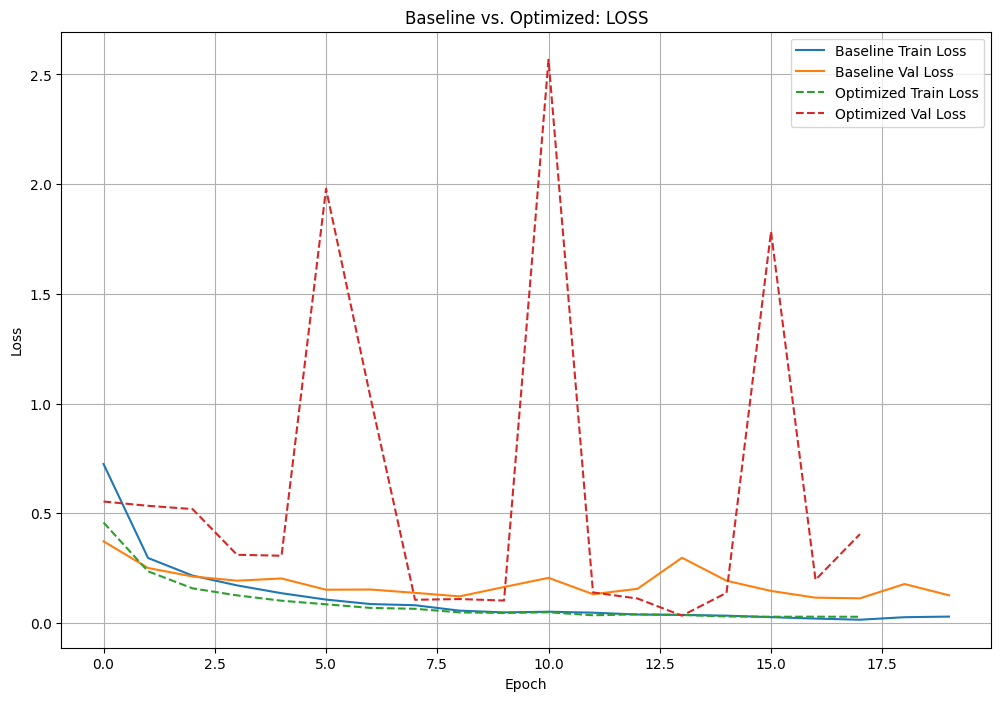

Loss Comparison plot displayed. Notice how the 'Optimized' validation line (red) is lower and more stable!


In [25]:
plt.figure(figsize=(12, 8))
plt.plot(history_baseline_df['loss'], label='Baseline Train Loss')
plt.plot(history_baseline_df['val_loss'], label='Baseline Val Loss')
plt.plot(history_optimized_df['loss'], label='Optimized Train Loss', linestyle='--')
plt.plot(history_optimized_df['val_loss'], label='Optimized Val Loss', linestyle='--')
plt.title("Baseline vs. Optimized: LOSS")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

print("Loss Comparison plot displayed. Notice how the 'Optimized' validation line (red) is lower and more stable!")

-----

### **Text Cell**

## Cell 18: Plot Comparison - Accuracy

Now let's do the same for accuracy.

**This is the proof:** The "Baseline" `val_accuracy` (orange) stalled or dropped as it overfit. The "Optimized" `val_accuracy` (red) should be **higher and more stable**, meaning it's a *better, more reliable* model.

-----

### **Code Cell**

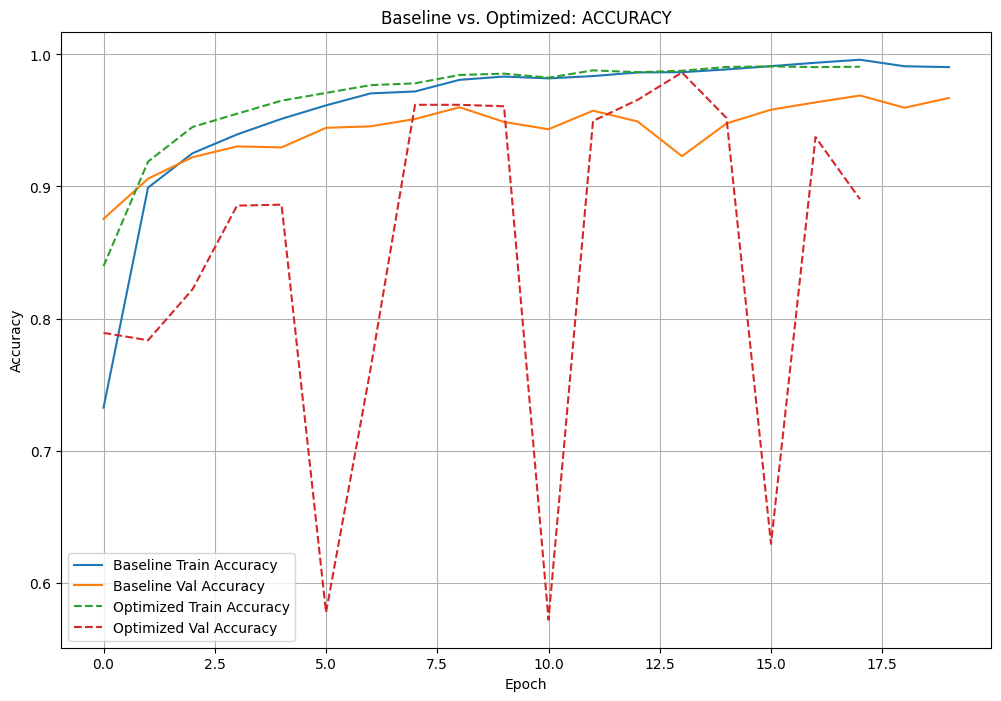

Accuracy Comparison plot displayed. Notice how the 'Optimized' validation line (red) is higher and tracks the training line better!


In [26]:
plt.figure(figsize=(12, 8))
plt.plot(history_baseline_df['accuracy'], label='Baseline Train Accuracy')
plt.plot(history_baseline_df['val_accuracy'], label='Baseline Val Accuracy')
plt.plot(history_optimized_df['accuracy'], label='Optimized Train Accuracy', linestyle='--')
plt.plot(history_optimized_df['val_accuracy'], label='Optimized Val Accuracy', linestyle='--')
plt.title("Baseline vs. Optimized: ACCURACY")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

print("Accuracy Comparison plot displayed. Notice how the 'Optimized' validation line (red) is higher and tracks the training line better!")

-----

### **Text Cell**

## Day 2 Conclusion

Look at those plots\! We have *visual proof* that our techniques worked.

**HIGHLIGHT: What We Did**

1.  **We PROVED Overfitting:** We built a *complex* "Basic" CNN and saw its validation accuracy (`val_accuracy`) stall while its validation loss (`val_loss`) went **UP**.
2.  **We LEARNED the Fixes:** We learned the theory behind `Dropout`, `BatchNormalization`, `L1/L2 Regularization`, and `EarlyStopping`.
3.  **We BUILT an "Efficient Net":** We built a *deeper and wider* "Pro" CNN and used `Dropout` and `BatchNormalization` to control it.
4.  **We PROVED the Fix:** Our final comparison plots show our new optimized "Pro" model:
      * Had a **much smaller gap** between training and validation lines (less overfitting).
      * Achieved a **higher, more stable validation accuracy** (beating the overfit baseline\!).
      * Stopped training **automatically** with `EarlyStopping` to save time and give us the best model.

We have successfully built a robust, stable, and "efficient" CNN.



##Part 6: (Bonus) Visualizing What the CNN Sees
This is a bonus section to help you understand what "compression" (or more accurately, feature extraction) looks like inside a CNN.

###How does a CNN "see"?

It's not "compression" like a .zip file. It's a process of feature extraction that gets more abstract with every layer:

Conv2D Layers (The "Feature Detectors"): A Conv2D layer applies a set of filters (like 32, 64, 128) to its input. Each filter is trained to find one specific, tiny pattern.

Early Layers: Filters learn to find simple things like vertical lines, horizontal lines, curves, or specific color blobs.

Deeper Layers: Filters learn to combine those simple patterns into more complex features, like "a round red shape" (an apple) or "a yellow curved texture" (a banana).

The output of this is a "feature map" that shows where in the image the filter found its pattern.

MaxPooling2D Layers (The "Compressors"): This is the part you're thinking of as compression. This layer simply shrinks the feature maps. It slides a window (e.g., 2x2) over the map and keeps only the strongest signal (the "max") from that window. This has two benefits:

It reduces the size of the data, making the model faster.

It makes the model more robust. It no longer cares exactly where the feature was, just that it was "in that general area."

Let's grab a test image and pass it through our model_optimized to see these feature maps in action.

### Visualizing the 64x64 Resize
You asked why we picked IMG_SIZE = 64. Let's visualize what that resizing looks like. We'll load one image from the disk twice: once in its original size and once resized to 64x64.

You can see how the 64x64 version is much smaller and "blockier," but it still keeps the main features (the apple's shape and color).

Loading example image: /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/freshapples/saltandpepper_Screen Shot 2018-06-08 at 5.18.26 PM.png


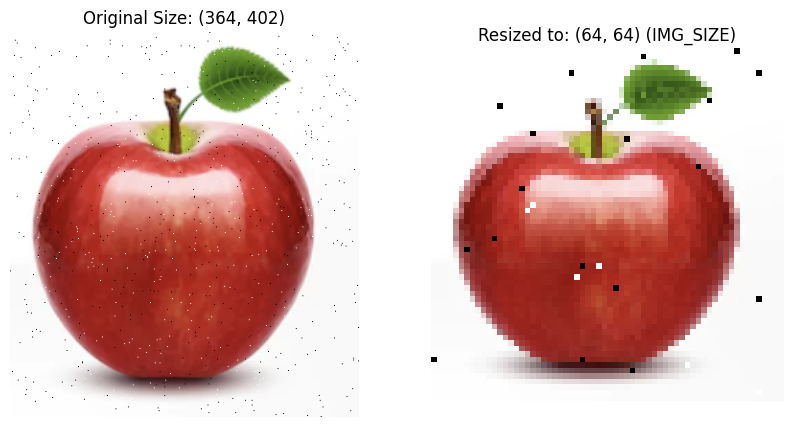

In [27]:
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
import os

# --- Find an example image ---
# NOTE: This assumes you have 'freshapples' folder in your train_dir
# We'll get the first image we find in that folder
try:
    example_img_folder = os.path.join(train_dir, 'freshapples')
    example_img_name = os.listdir(example_img_folder)[0]
    example_img_path = os.path.join(example_img_folder, example_img_name)

    print(f"Loading example image: {example_img_path}")

    # --- Load images ---
    # 1. Load the original
    original_img = load_img(example_img_path)

    # 2. Load the 64x64 version
    resized_img = load_img(example_img_path, target_size=(IMG_SIZE, IMG_SIZE))

    # --- Plot them side-by-side ---
    plt.figure(figsize=(10, 5))

    # Plot Original
    plt.subplot(1, 2, 1)
    plt.title(f"Original Size: {original_img.size}")
    plt.imshow(original_img)
    plt.axis('off')

    # Plot Resized
    plt.subplot(1, 2, 2)
    plt.title(f"Resized to: {resized_img.size} (IMG_SIZE)")
    plt.imshow(resized_img)
    plt.axis('off')

    plt.show()

except FileNotFoundError:
    print("\n---")
    print("Could not find the 'freshapples' directory to load an example.")
    print(f"Please make sure your train_dir is set correctly. Current path: {train_dir}")
except Exception as e:
    print(f"An error occurred: {e}")

Test Image Label: freshoranges


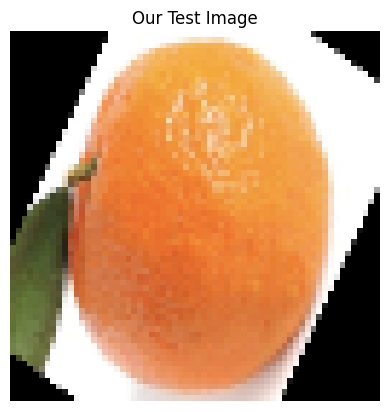


Activation model created. Ready to predict and plot.


In [28]:
# --- Cell (Bonus 1): Setup for Visualization ---

# First, let's get a single image from our validation dataset
image_batch, label_batch = next(iter(val_ds))
test_image = image_batch[0]
test_label = label_batch[0]

# The model expects a "batch" of images, so we add a batch dimension
# (64, 64, 3) -> (1, 64, 64, 3)
test_image_batch = tf.expand_dims(test_image, 0)

# Let's see the image we're testing
print(f"Test Image Label: {class_names[np.argmax(test_label)]}")
plt.imshow(test_image.numpy().astype("uint8"))
plt.title("Our Test Image")
plt.axis("off")
plt.show()

# --- THIS IS THE FIX ---
# We are using the *actual* layer names from our new Functional model_baseline
layer_names = [
    'conv2d_1',          # Block 1 (16 filters)
    'max_pooling2d_1',   # Block 1
    'conv2d_2',          # Block 2 (32 filters)
    'max_pooling2d_2',   # Block 2
]

# Get the layer objects from the 'model_baseline' you just trained
layer_outputs = [model_baseline.get_layer(name).output for name in layer_names]

# Create the activation model. This now works!
activation_model = tf.keras.Model(inputs=model_baseline.input, outputs=layer_outputs)

print("\nActivation model created. Ready to predict and plot.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
Plotting feature maps... (This may take a moment)


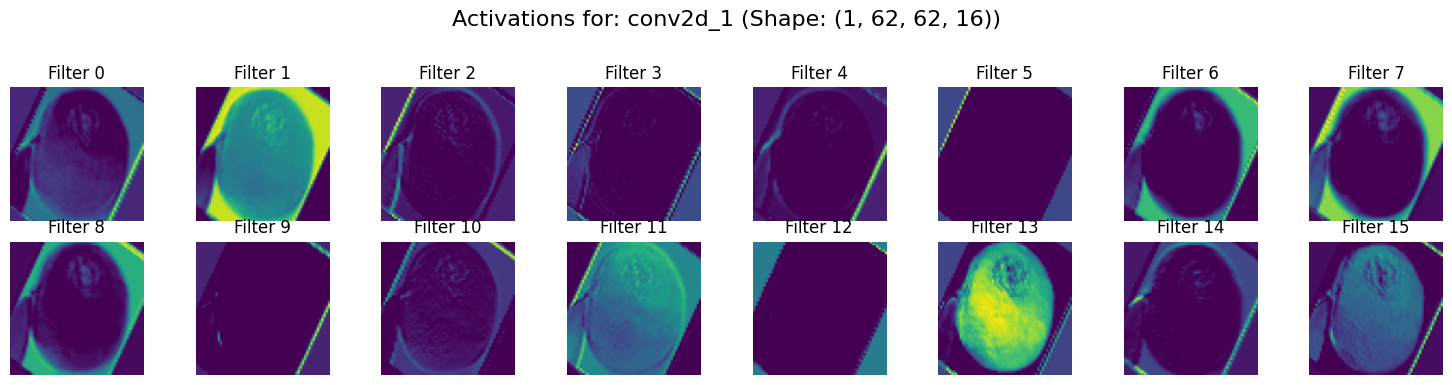

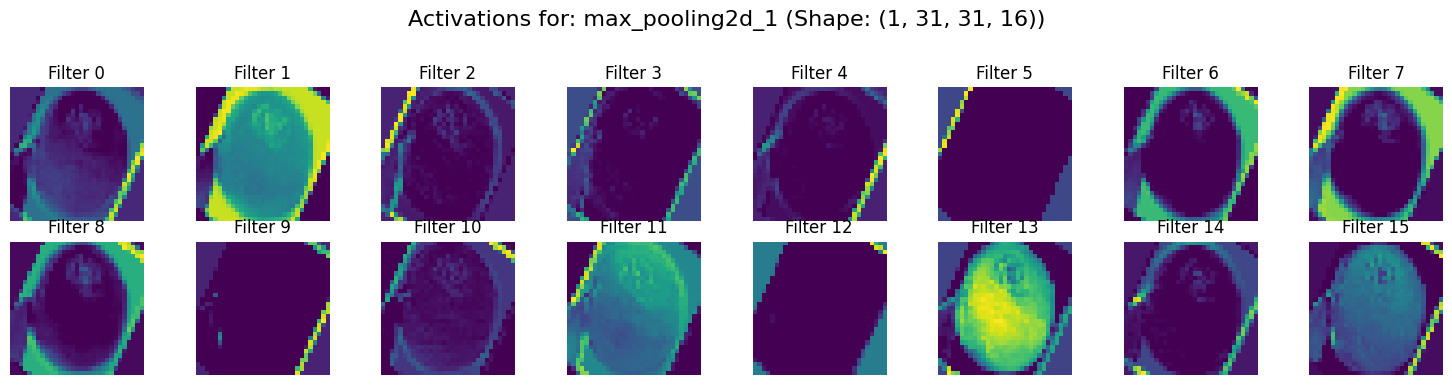

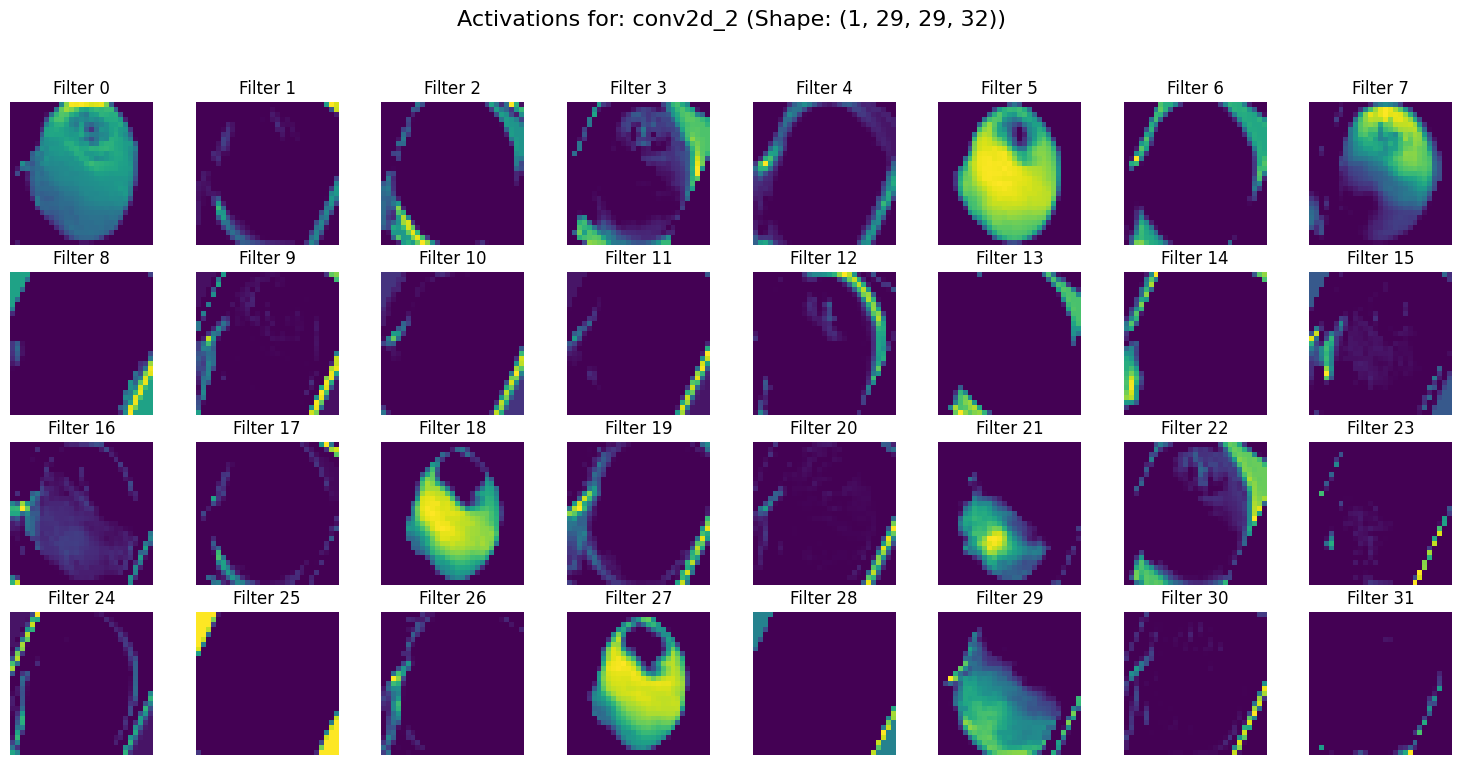

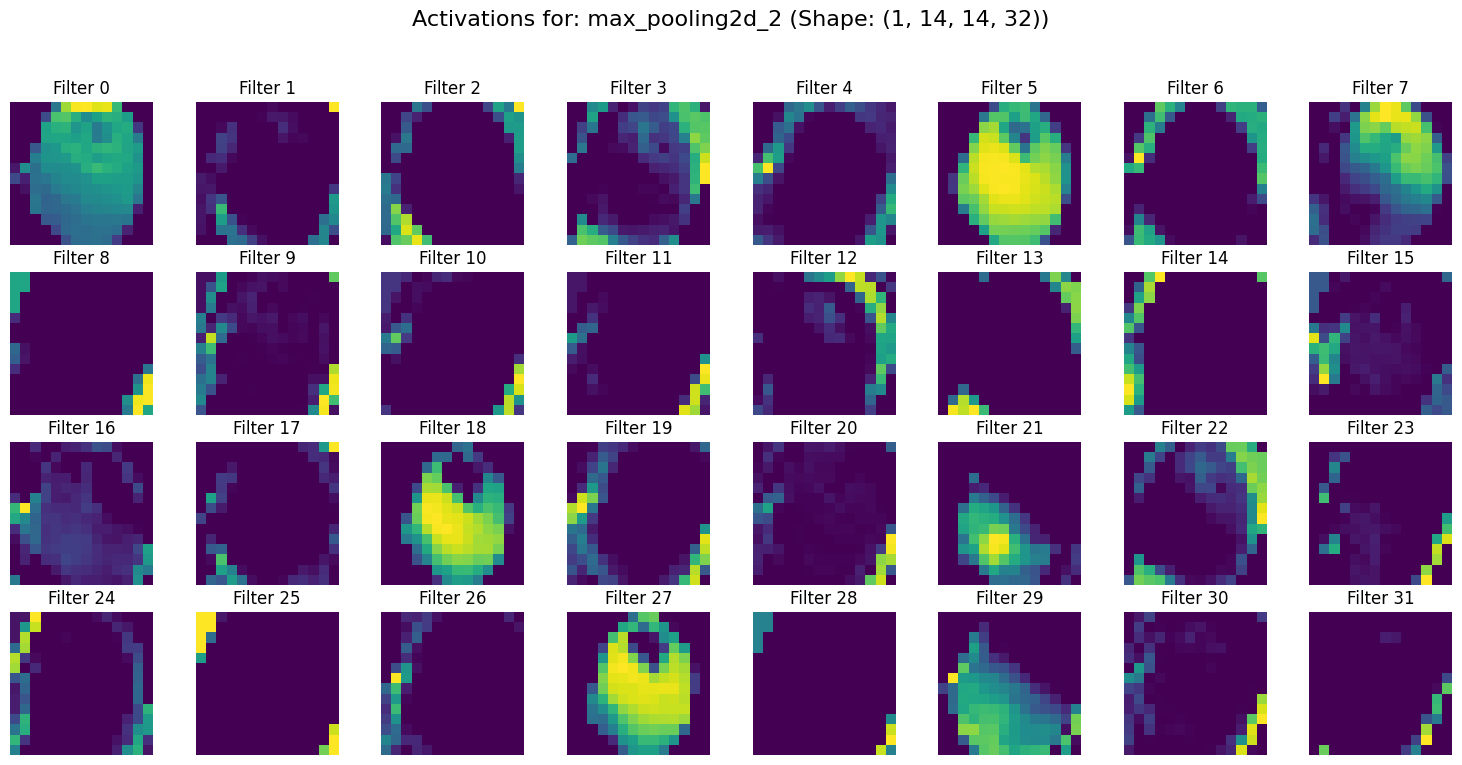

Plotting complete.


In [29]:
# --- Cell (Bonus 2): Plot the Feature Maps ---
# This will take a moment to run

# Get the feature maps from our test image
activations = activation_model.predict(test_image_batch)

# A helper function to plot the feature maps
def plot_feature_maps(layer_name, feature_maps, max_cols=8):
    num_maps = feature_maps.shape[-1]  # Number of filters in this layer
    cols = min(num_maps, max_cols)     # Max 8 maps per row
    rows = (num_maps + cols - 1) // cols # Calculate needed rows

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 2))
    fig.suptitle(f"Activations for: {layer_name} (Shape: {feature_maps.shape})", fontsize=16)

    # Handle the case of a single row
    if rows == 1:
        axes = [axes]

    # Handle the case of a single map
    if num_maps == 1:
        axes = [[axes]]

    # Loop over all feature maps and plot them
    map_idx = 0
    for r in range(rows):
        for c in range(cols):
            if map_idx < num_maps:
                # Use .T to transpose for display if axes is 1D
                ax = axes[r][c] if rows > 1 else axes[c]

                # Squeeze the batch dimension and plot the feature map
                ax.imshow(feature_maps[0, :, :, map_idx], cmap='viridis')
                ax.set_title(f"Filter {map_idx}")
                ax.axis("off")
                map_idx += 1
            else:
                # Hide unused subplots
                ax = axes[r][c] if rows > 1 else axes[c]
                ax.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Plot the activations for each layer ---
# We'll plot all filters from each layer

print("Plotting feature maps... (This may take a moment)")

# Block 1: Conv2D (16 filters)
plot_feature_maps(layer_names[0], activations[0], max_cols=8)

# Block 1: MaxPooling2D (16 maps, but smaller)
plot_feature_maps(layer_names[1], activations[1], max_cols=8)

# Block 2: Conv2D (32 filters)
plot_feature_maps(layer_names[2], activations[2], max_cols=8)

# Block 2: MaxPooling2D (Final output before Flatten)
plot_feature_maps(layer_names[3], activations[3], max_cols=8)

print("Plotting complete.")

##Cell: Visualizing Model (CNN) Predictions
Now for the final test you asked for! Let's take random images from our validation (test) set and see what our new CNN model predicted.

We'll use the same Green (Correct) / Red (Incorrect) system. With ~96% accuracy, we should expect to see almost all green.

Making predictions with model_baseline on a batch of validation images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Plotting CNN prediction grid...


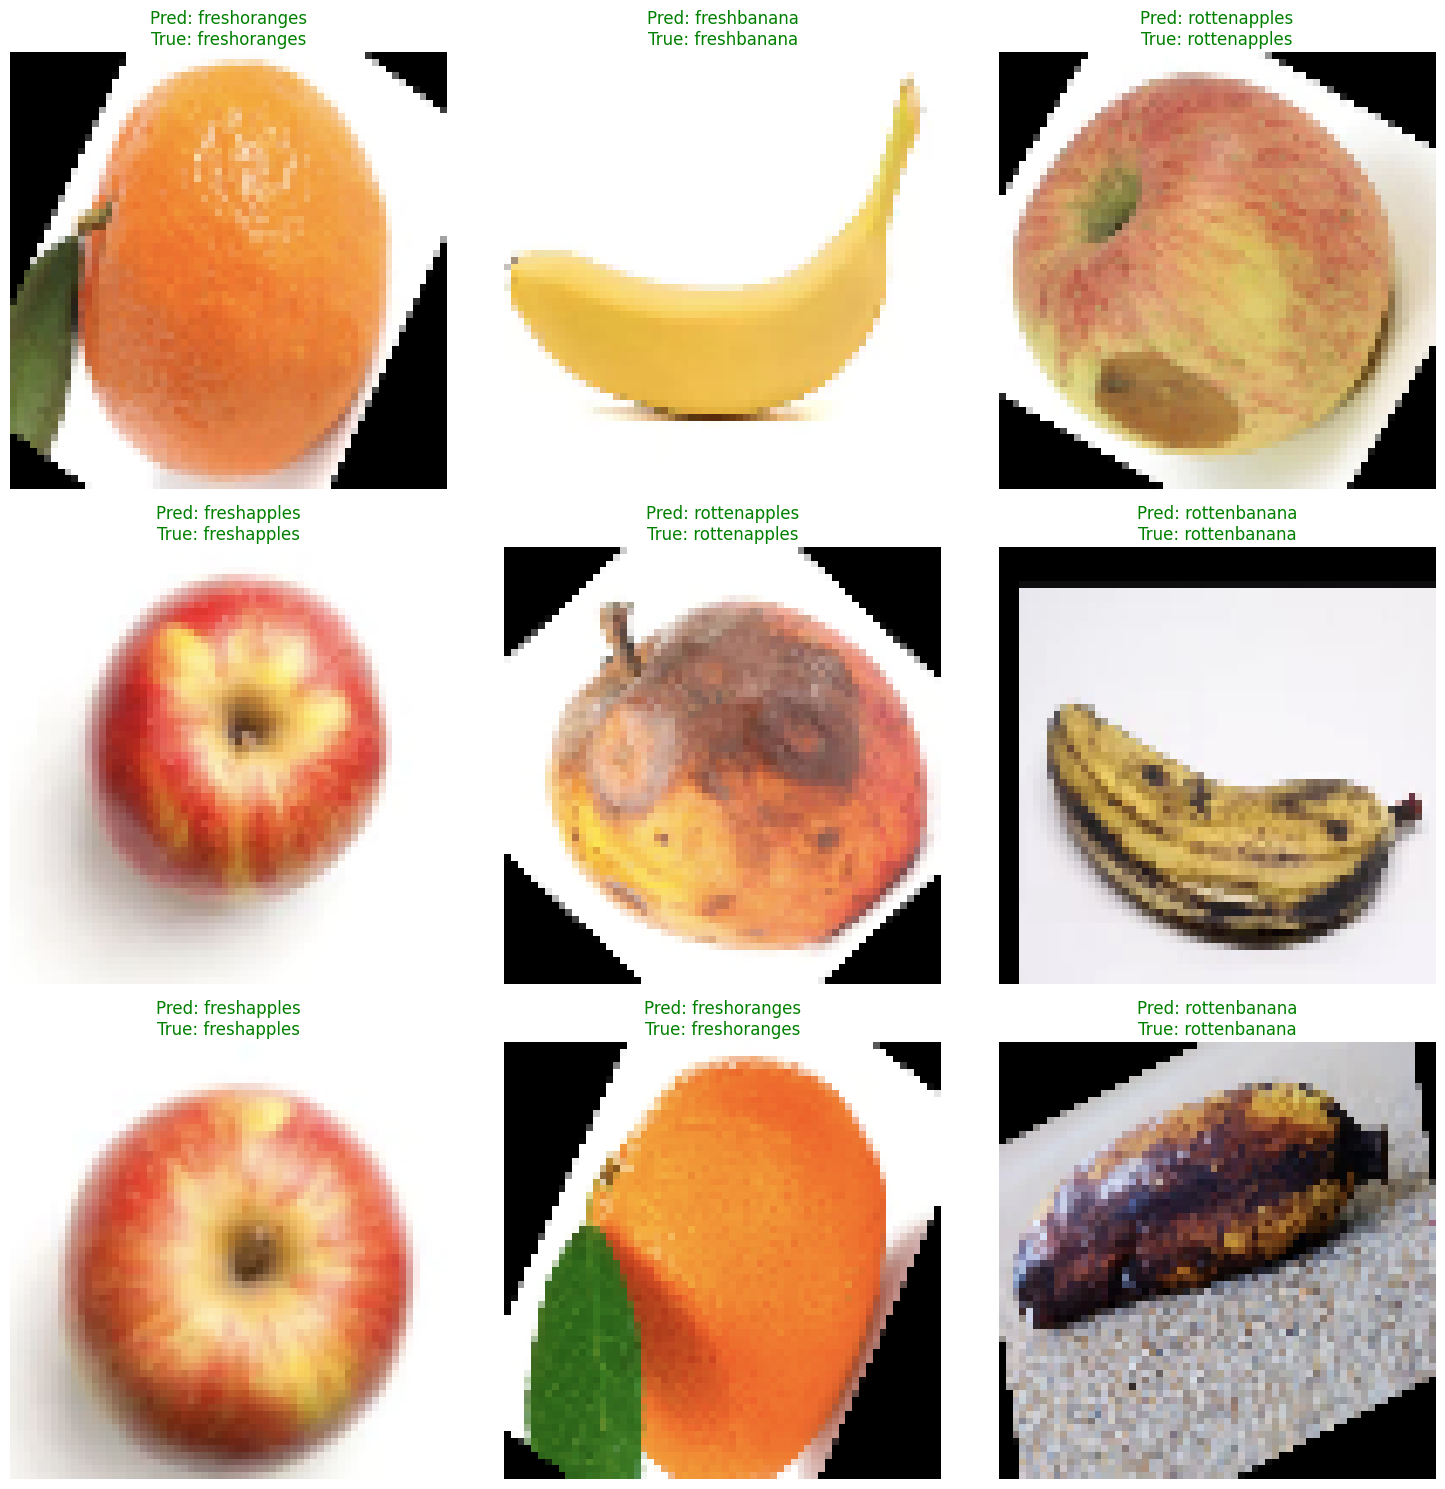

In [30]:
# Get one batch of images and labels from the validation set
# We use next(iter(...)) to grab a single batch
images_batch, labels_batch = next(iter(val_ds))

# Make predictions on this batch using the CNN
print("Making predictions with model_baseline on a batch of validation images...")
predictions_batch = model_baseline.predict(images_batch)

# Get the predicted class indices
predicted_indices = np.argmax(predictions_batch, axis=1)
# Get the true class indices
true_indices = np.argmax(labels_batch.numpy(), axis=1)

# --- Plot the results ---
plt.figure(figsize=(15, 15))
print("Plotting CNN prediction grid...")

# We'll plot the first 9 images in the batch
for i in range(9):
    plt.subplot(3, 3, i + 1)

    # Show the image
    plt.imshow(images_batch[i].numpy().astype("uint8"))

    # Get the predicted and true labels
    pred_label = class_names[predicted_indices[i]]
    true_label = class_names[true_indices[i]]

    # Set the color
    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()